In [2]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.91MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.49MB/s]


In [4]:
mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.9 * len(mnist_testset)), int(0.1 * len(mnist_testset))])

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))


Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


In [5]:
import torch

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

In [9]:
model = Model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

if (torch.cuda.is_available()):
    model.cuda()

no_epochs = 40
train_loss = list()
val_loss = list()
best_val_loss = 1

for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # validation
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")



Epoch: 1/40, Train Loss: 0.29221394, Val Loss: 0.05539485, Val Accuracy: 0.98255556
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.05539485

Epoch: 2/40, Train Loss: 0.10319900, Val Loss: 0.04072479, Val Accuracy: 0.98644444
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.04072479

Epoch: 3/40, Train Loss: 0.07518058, Val Loss: 0.03363560, Val Accuracy: 0.98922222
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.03363560

Epoch: 4/40, Train Loss: 0.06278790, Val Loss: 0.02889560, Val Accuracy: 0.98944444
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.02889560

Epoch: 5/40, Train Loss: 0.05377079, Val Loss: 0.02593378, Val Accuracy: 0.99177778
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.02593378

Epoch: 6/40, Train Loss: 0.04695768, Val Loss: 0.02863875, Val Accuracy: 0.99200000

Epoch: 7/40, Train Loss: 0.03957879, Val Loss: 0.02301632, Val Accuracy: 0.99233333
Savin

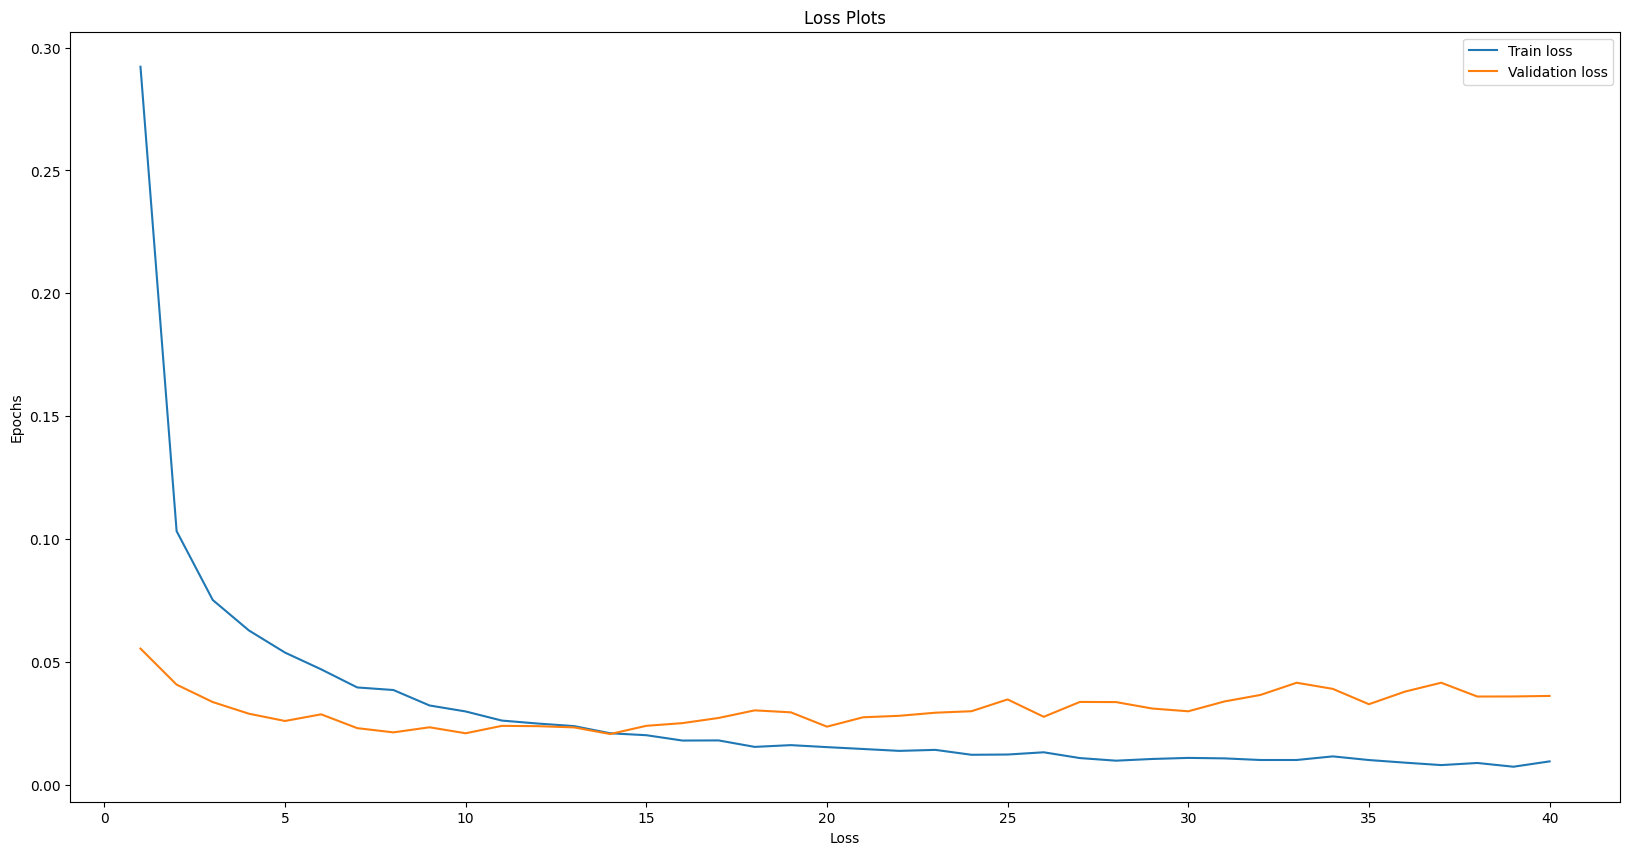

In [10]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

Test accuracy 0.9920


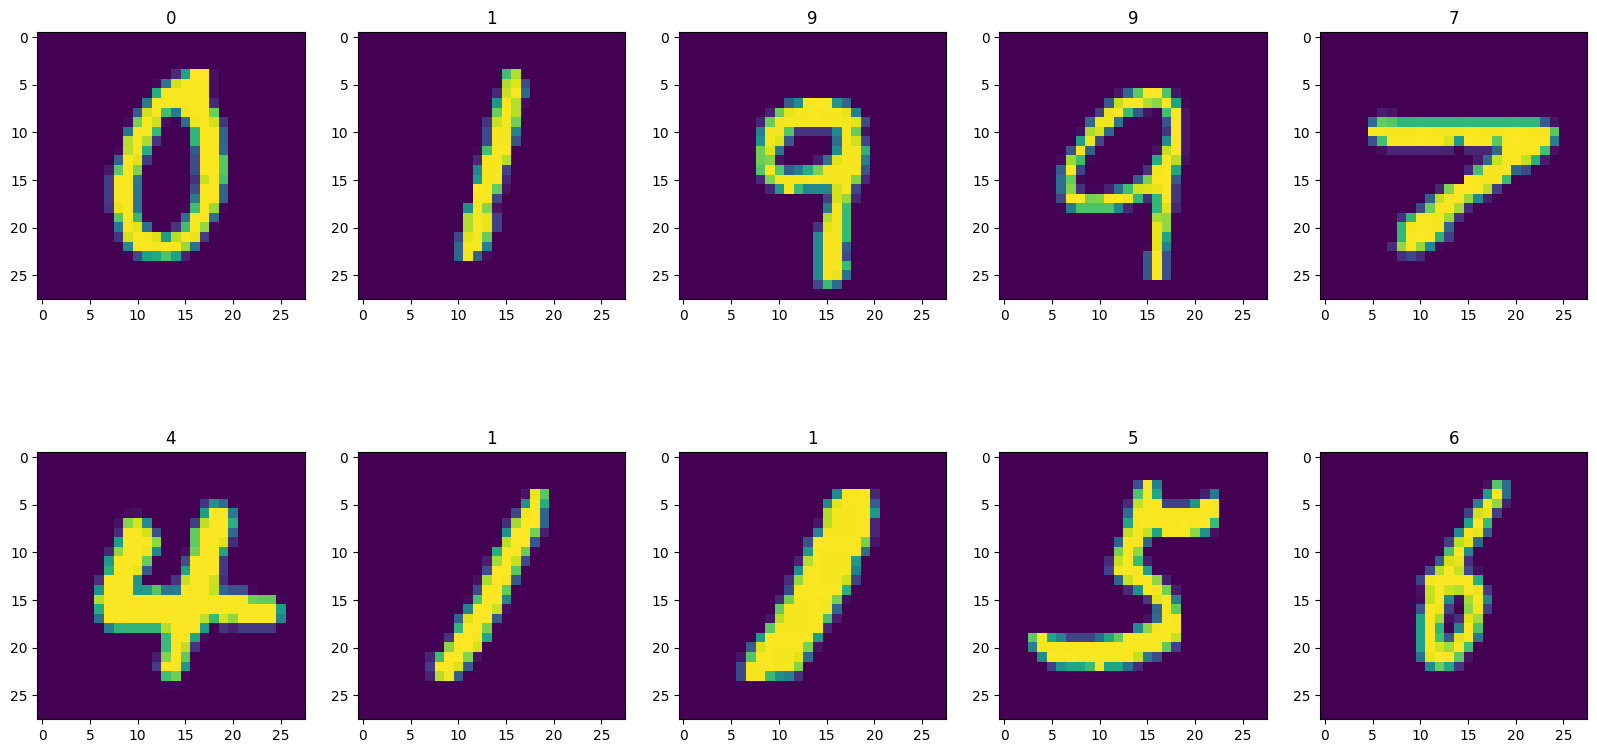

In [11]:
# Test model
model.load_state_dict(torch.load("model.dth"))
model.eval()

correct = 0
total = 0
results = []

with torch.no_grad():
    for image, label in test_dataloader:
        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()

        pred = model(image)
        predicted = torch.argmax(pred, dim=1)

        correct += (predicted == label).sum().item()
        total += label.size(0)

        for img, lab in zip(image, predicted):
            results.append((img.cpu(), lab.cpu()))

test_accuracy = correct / total
print('Test accuracy {:.4f}'.format(test_accuracy))


# visualize results
fig=plt.figure(figsize=(20, 10))
for i in range(1, 11):
    img = transforms.ToPILImage(mode='L')(results[i][0].squeeze(0).detach().cpu())
    fig.add_subplot(2, 5, i)
    plt.title(results[i][1].item())
    plt.imshow(img)
plt.show()